# Single Particle Diffusion Simulation

This notebook generates simulated single particle diffusion sequences for four types of motion:
1. Normal Diffusion
2. Directed Motion
3. Confined Diffusion (Circular Boundary)
4. Fractional Brownian Motion (FBM)

It also generates corresponding image sequences and visualizes the results.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.linalg import cholesky

# Try importing tifffile for saving images, otherwise use numpy save
try:
    import tifffile
    HAS_TIFFFILE = True
except ImportError:
    HAS_TIFFFILE = False
    print("tifffile not found. Sequences will be saved as .npy files.")

# Ensure output directory exists
OUTPUT_DIR = "Simulated_Data"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

%matplotlib inline

tifffile not found. Sequences will be saved as .npy files.


In [4]:
# --- Parameters ---
NUM_SEQUENCES = 20      # Number of sequences per diffusion type
NUM_FRAMES = 50         # Frames per sequence
IMAGE_SIZE = (64, 64)   # (Height, Width)
PARTICLE_SIGMA = 1.5    # Gaussian sigma in pixels
INTENSITY = 1000        # Peak intensity
BACKGROUND = 10         # Background level
NOISE_LEVEL = 5         # Poisson/Gaussian noise level (optional)

# Diffusion Parameters
D_NORMAL = 0.5          # Diffusion coefficient for Normal
VELOCITY = 0.8          # Velocity for Directed
D_DIRECTED = 0.1        # Diffusion component for Directed
D_CONFINED = 0.5        # Diffusion for Confined
CONFINEMENT_RADIUS = 10 # Radius in pixels
H_FBM = 0.3             # Hurst parameter for FBM (Sub-diffusive < 0.5)
D_FBM = 0.5             # Diffusion coefficient equivalent for FBM scale

In [5]:
# --- Simulation Functions ---

def generate_normal_diffusion(n_frames, D):
    """Generates a 2D random walk."""
    # Standard deviation of step size = sqrt(2*D)
    # assuming dt=1 for simplicity
    scale = np.sqrt(2 * D)
    steps = np.random.normal(loc=0, scale=scale, size=(n_frames, 2))
    # Start at random position within central area
    start_pos = (np.array(IMAGE_SIZE) / 2) + np.random.uniform(-5, 5, size=2)
    traj = np.cumsum(np.vstack([start_pos, steps[:-1]]), axis=0)
    return traj

def generate_directed_motion(n_frames, v, D):
    """Generates directed motion with diffusion."""
    scale = np.sqrt(2 * D)
    steps_diff = np.random.normal(loc=0, scale=scale, size=(n_frames, 2))
    
    # Random direction
    theta = np.random.uniform(0, 2*np.pi)
    v_vec = np.array([v * np.cos(theta), v * np.sin(theta)])
    
    traj = np.zeros((n_frames, 2))
    start_pos = (np.array(IMAGE_SIZE) / 2) + np.random.uniform(-10, 10, size=2)
    traj[0] = start_pos
    
    for t in range(1, n_frames):
        traj[t] = traj[t-1] + v_vec + steps_diff[t-1]
        
    return traj

def generate_confined_diffusion(n_frames, D, radius):
    """Generates diffusion confined within a circle."""
    scale = np.sqrt(2 * D)
    center = np.array(IMAGE_SIZE) / 2
    traj = np.zeros((n_frames, 2))
    
    # Start inside
    r_start = np.random.uniform(0, radius - 2)
    theta_start = np.random.uniform(0, 2*np.pi)
    start_pos = center + r_start * np.array([np.cos(theta_start), np.sin(theta_start)])
    traj[0] = start_pos
    
    for t in range(1, n_frames):
        step = np.random.normal(loc=0, scale=scale, size=2)
        proposed = traj[t-1] + step
        
        # Check distance from center
        dist = np.linalg.norm(proposed - center)
        if dist <= radius:
            traj[t] = proposed
        else:
            # Reflective boundary (simplified: just reject step or reflect)
            # Proper reflection: find intersection and reflect vector
            # Simplest valid approximation for small steps: stay put or re-roll
            # Better: Reflect against the tangent at collision point
            
            # Vector from center to proposed
            v_radial = proposed - center
            v_radial_norm = v_radial / np.linalg.norm(v_radial)
            
            # Reflect proposed point back across the boundary circle tangent?
            # Easier: Elastic collision logic. 
            # Let's use a "push back" method for simplicity which approximates reflection
            # proposed = center + (radius - (dist - radius)) * v_radial_norm
            # This mirrors the point across the boundary circle arc roughly
            
            new_dist = radius - (dist - radius)
            traj[t] = center + new_dist * v_radial_norm
            
    return traj

def generate_fbm(n_frames, H, D):
    """Generates Fractional Brownian Motion using Cholesky decomposition."""
    # Covariance matrix for FBM: E[B_t B_s] = 0.5 * (t^(2H) + s^(2H) - |t-s|^(2H))
    # We need to generate two independent 1D FBMs for X and Y.
    
    t = np.arange(n_frames)
    s, t_grid = np.meshgrid(t, t)
    # Covariance matrix scaled by diffusion constant
    # MSD(Total) = 4*D*t^(2H) -> 2*D per dimension
    # Cov(B_t, B_s) formula gives E[B_t^2] = t^(2H). So we scale by sqrt(2*D)
    
    cov = 0.5 * (t_grid**(2*H) + s**(2*H) - np.abs(t_grid - s)**(2*H))
    # Add small epsilon for numerical stability
    cov += np.eye(n_frames) * 1e-6
    
    L = cholesky(cov, lower=True)
    
    # Generate uncorrelated Gaussian noise
    noise_x = np.random.normal(0, 1, n_frames)
    noise_y = np.random.normal(0, 1, n_frames)
    
    path_x = L @ noise_x
    path_y = L @ noise_y
    
    # Scale and center
    scale = np.sqrt(2 * D)
    start_pos = (np.array(IMAGE_SIZE) / 2) + np.random.uniform(-5, 5, size=2)
    
    traj = np.column_stack([path_x, path_y]) * scale + start_pos
    return traj


In [6]:
# --- Image Generation ---

def traj_to_images(traj, image_size, sigma, intensity=1000, bg=10):
    """Converts a trajectory to a sequence of images with Gaussian PSF."""
    n_frames = len(traj)
    H, W = image_size
    images = np.zeros((n_frames, H, W), dtype=np.float32)
    
    Y, X = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
    
    for t in range(n_frames):
        x0, y0 = traj[t]
        # Gaussian PDF: exp(-((x-x0)^2 + (y-y0)^2) / (2*sigma^2))
        gauss = np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2))
        images[t] = bg + intensity * gauss
    
    # Add noise (Poisson shot noise + Gaussian read noise)
    # Simulated roughly
    images = np.random.poisson(images).astype(np.float32)
    
    return images

In [7]:
# --- Main Execution ---

data_storage = {}

diffusion_types = ['Normal', 'Directed', 'Confined', 'FBM']

for dtype in diffusion_types:
    print(f"Generating {dtype} sequences...")
    sequences = []
    trajectories = []
    
    for i in range(NUM_SEQUENCES):
        if dtype == 'Normal':
            traj = generate_normal_diffusion(NUM_FRAMES, D_NORMAL)
        elif dtype == 'Directed':
            traj = generate_directed_motion(NUM_FRAMES, VELOCITY, D_DIRECTED)
        elif dtype == 'Confined':
            traj = generate_confined_diffusion(NUM_FRAMES, D_CONFINED, CONFINEMENT_RADIUS)
        elif dtype == 'FBM':
            traj = generate_fbm(NUM_FRAMES, H_FBM, D_FBM)
            
        imgs = traj_to_images(traj, IMAGE_SIZE, PARTICLE_SIGMA, INTENSITY, BACKGROUND)
        
        sequences.append(imgs)
        trajectories.append(traj)
        
    data_storage[dtype] = {
        'images': sequences,
        'trajectories': trajectories
    }

print("Done generating data.")

Generating Normal sequences...
Generating Directed sequences...
Generating Confined sequences...
Generating FBM sequences...
Done generating data.


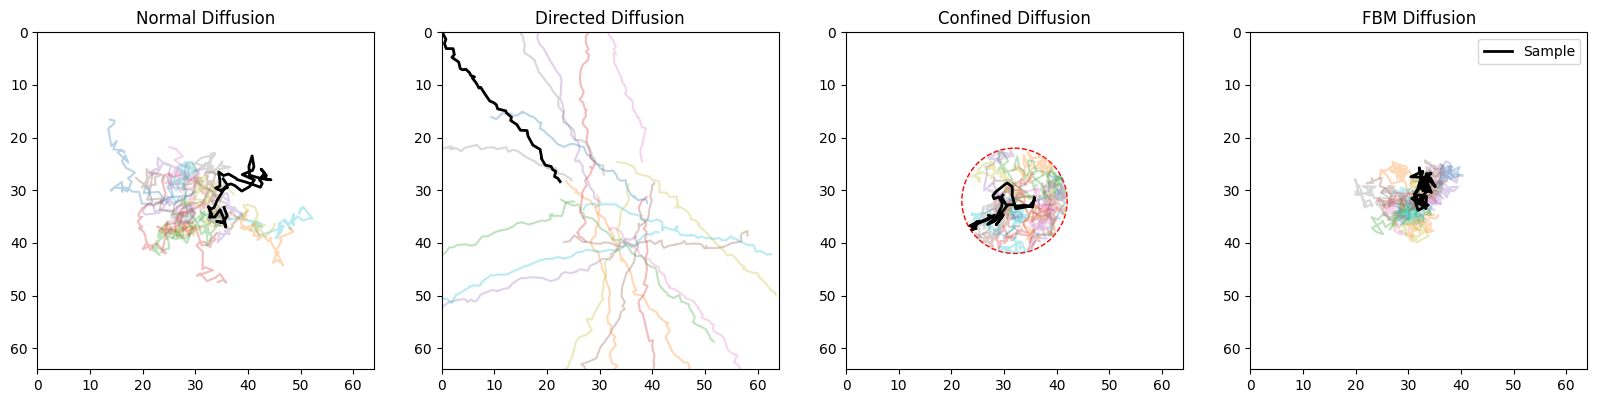

In [8]:
# --- Visualization ---

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, dtype in enumerate(diffusion_types):
    ax = axes[i]
    trajs = data_storage[dtype]['trajectories']
    
    # Plot all trajectories mostly transparent
    for tr in trajs:
        ax.plot(tr[:, 0], tr[:, 1], alpha=0.3)
        
    # Highlight one
    ax.plot(trajs[0][:, 0], trajs[0][:, 1], 'k-', linewidth=2, label='Sample')
    
    if dtype == 'Confined':
        circle = plt.Circle(tuple(np.array(IMAGE_SIZE)/2), CONFINEMENT_RADIUS, 
                            color='r', fill=False, linestyle='--')
        ax.add_patch(circle)
        
    ax.set_title(f"{dtype} Diffusion")
    ax.set_xlim(0, IMAGE_SIZE[1])
    ax.set_ylim(0, IMAGE_SIZE[0])
    ax.set_aspect('equal')
    ax.invert_yaxis() # Match image coords

plt.legend()
plt.show()

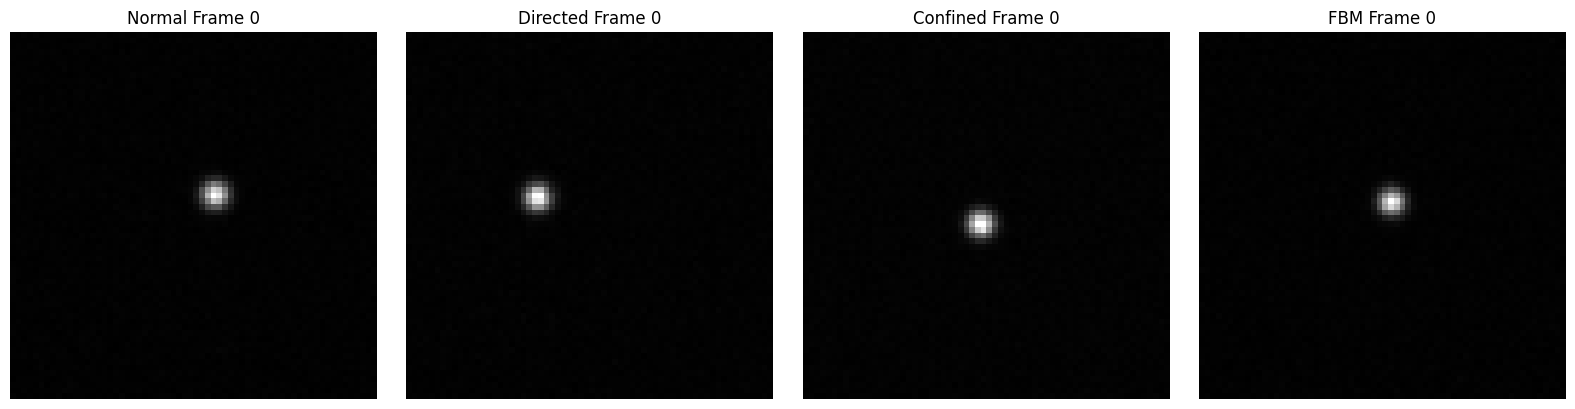

In [9]:
# --- Sample Frame Visualization ---

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, dtype in enumerate(diffusion_types):
    ax = axes[i]
    # Show first frame of first sequence
    img_sample = data_storage[dtype]['images'][0][0]
    
    ax.imshow(img_sample, cmap='gray')
    ax.set_title(f"{dtype} Frame 0")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# --- Save Data ---

for dtype in diffusion_types:
    # Stack all sequences for a type? Or save individual files?
    # Saving individual sequences to easy inspection
    start_path = os.path.join(OUTPUT_DIR, dtype)
    if not os.path.exists(start_path):
        os.makedirs(start_path)
        
    for seq_idx, (imgs, traj) in enumerate(zip(data_storage[dtype]['images'], 
                                               data_storage[dtype]['trajectories'])):
        
        # Save Images
        # Cast to uint16 (standard for microscopy)
        imgs_uint16 = imgs.astype(np.uint16)
        
        filename_img = os.path.join(start_path, f"seq_{seq_idx:03d}.tif")
        if HAS_TIFFFILE:
            tifffile.imwrite(filename_img, imgs_uint16)
        else:
            np.save(filename_img.replace('.tif', '.npy'), imgs_uint16)
            
        # Save Trajectory (CSV or NPY)
        filename_traj = os.path.join(start_path, f"traj_{seq_idx:03d}.npy")
        np.save(filename_traj, traj)

print(f"Data saved to {os.path.abspath(OUTPUT_DIR)}")

Data saved to e:\Projects\3_ORC\04_codes\WF-Acq-py\Simulated_Data
